
<H1 style=text-align:center;>Projet de Licence en Informatique parcours Math-INFO</H1>
<h1 style=text-align:center;>Enseignante : Raquel URENA</h3>

<h2 style=text-align:center;>Sujet choisi: </h3>
<h2 style=text-align:center;>Réseaux Bayésiens pour la Décision Clinique Interprétable</h3>

<h2 style=text-align:center;>Membres du groupe par ordre alphabétique:</h3>
<h2 style=text-align:center;>Joséphine HERMANS, Hiromi SUIDO, Michael TEIXEIRA </h3>

# Plan de développement

# Gestion de configuration
L'équipe utilise github pour gérer la configuration du projet. Le repository github possède une branch nommée 'main'. 
- Lorsqu'un membre de l'équipe developpe une nouvelle fonctionalité, celle-ci doit être developpée dans une branche.
- lorsque le d2veloppement de la fonctionnalité est terminée, le membre d'équipe créer une merge request dans github
- la merge request est revue par un membre de l'équipe.
- si la fonctionnalité est bonne, la branche peut être mergée avec la branche 'main'.

## Libarie python utilisée

In [1]:
from IPython.display import Image
import pandas as pd

## Outils utilisés

- Notebook jupyter: pour le rapport et le code
- Python 3: language utilisé pour développer le programme et le notebook
- Drawio: Pour créer les schémas
- ...

# Vérification du code
La vérification du code est faite par une vérification du guide PEP8. Le code est aussi vérifié par revue du code par un membre de l'équipe avant merge dans la branche master du code sur github

# Validation
- La validation du code doit passer par des tests unitaires dont le nom de fonction commence par "test_".
- ...

## Planning
Voici le planning suivi par notre projet:

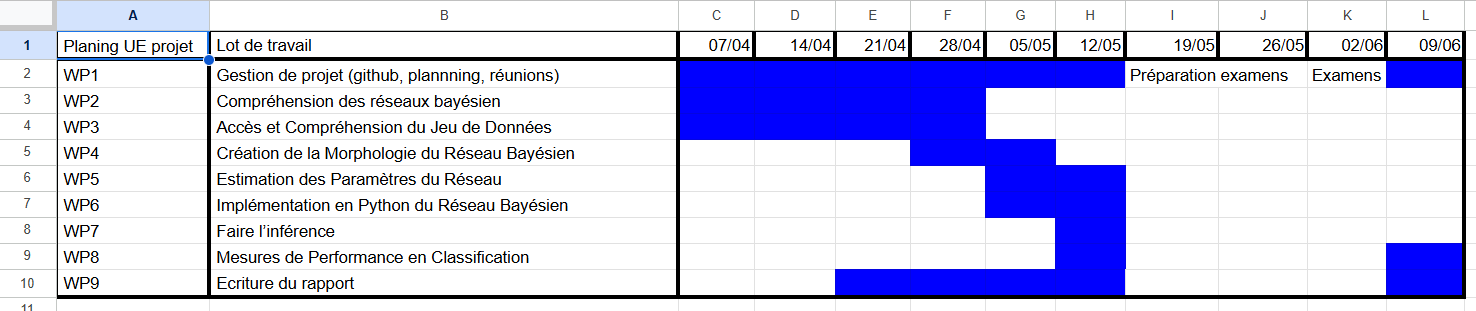

In [ ]:
Image("ressources/planning.png")

Le développement suit un modèle V tel que vu ci-dessous

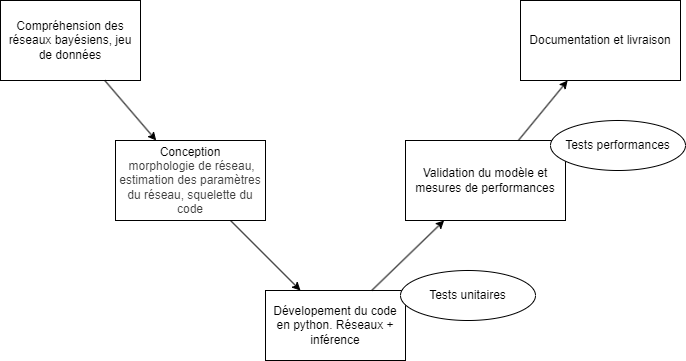

In [ ]:
Image("ressources/dev_plan.png")

# Préparation des données

In [ ]:
pd.read_csv("data/diabetes.csv")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
